In [1]:
import numpy as np               
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from scipy.stats import norm

# 密度比の推定

In [2]:
# データ設定 
n, m = 100, 200
nu_mean, nu_sd = -0.5, 1
a_mean,  a_sd = 1, 0.8
newdat = np.linspace(-4,4,500).reshape(500,1)  # 予測点
tnu =  norm.pdf(newdat, nu_mean, nu_sd)            # 確率密度の計算
tde = (norm.pdf(newdat, a_mean, a_sd)+tnu)/2
tw = tnu/tde                                   # 予測点上での真の密度比

In [3]:
# データ生成
nu = np.random.normal(loc=nu_mean, scale=nu_sd, size=n).reshape(n,1)
ma = np.random.binomial(m,0.5); mb = m-ma
de = np.r_[np.random.normal(loc=nu_mean,scale=nu_sd,size=ma).reshape(ma,1), np.random.normal(loc=a_mean, scale=a_sd, size=mb).reshape(mb,1)]

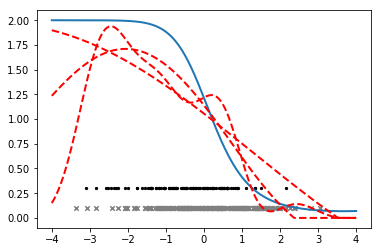

In [4]:
from common.DensityRatio import kernelDensityRatio
plt.plot(newdat,tw,lw=2)            # 真の密度比関数のプロット
# データ点のプロット
plt.scatter(nu.reshape(n,),np.repeat(0.3,n),marker='.',c='black',s=20)
plt.scatter(de.reshape(m,),np.repeat(0.1,m),marker='x',c='gray',s=20)
# 以下のカーネル幅で推定
gammas = np.array([0.01, 0.1, 1])
for g in gammas:
    dr = kernelDensityRatio(gamma=g)
    dr.fit(de,nu)                   # データへのフィッティング
    drp = dr.predict(newdat)        # 密度比の予測値
    plt.plot(newdat,drp, c='red',linestyle='dashed',lw=2)  # プロット
plt.show()   

# 密度比推定のための交差検証法

In [5]:
from scipy.spatial import distance        # distanceの計算
cvk = 5                                                      # 交差検証法のK
n, m = nu.shape[0], de.shape[0]          # データ数
# カーネル幅パラメータの候補を生成
idx = np.random.choice(n+m,round((n+m)/2))
gammas = 1/np.percentile(distance.pdist(np.r_[nu,de][idx,:]),[1,99])**2
gammas = np.logspace(np.log10(gammas.min()/100), np.log10(gammas.max()*100),10)
# 正則化パラメータ lambda の候補を生成 
lams = np.array([(min(n,m))**(-0.9)])
# モデルパラメータの候補
modelpars = np.array([(x,y) for x in gammas for y in lams])  

In [6]:
from common.DensityRatio import kernelDensityRatio
# それぞれのデータを5グループに分ける
inu = np.repeat(np.arange(cvk),np.ceil(n/cvk))
inu = inu[np.random.choice(n,n,replace=False)]
ide = np.repeat(np.arange(cvk),np.ceil(m/cvk))
ide = ide[np.random.choice(m,m,replace=False)]
cvloss = []
for gamma, lam in modelpars:
    tcvloss = []
    for k in np.arange(cvk):
        # トレーニングデータ
        trnu, trde = nu[inu!=k,:], de[ide!=k,:]
        # テストデータ
        tenu, tede = nu[inu==k,:], de[ide==k,:]
        # 指定されたモデルパラメータで密度比を推定
        kdr =kernelDensityRatio(gamma=gamma, lam=lam)
        kdr.fit(trde, trnu)                             # 推定
        wde = kdr.predict(tede)                         # de上で予測
        wnu = kdr.predict(tenu)                         # nu上で予測
        tcvloss.append(np.mean(wde**2)/2-np.mean(wnu))  # 二乗損失
    cvloss.append(np.mean(tcvloss))
# 最適なモデルパラメータ
optgamma,optlam = modelpars[np.argmin(cvloss),:]
optgamma,optlam

(0.058736149499858691, 0.015848931924611134)

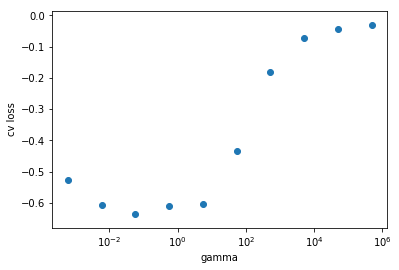

In [7]:
plt.xscale('log'); plt.xlabel('gamma'); plt.ylabel('cv loss')
plt.scatter(gammas, cvloss)
plt.show()

In [8]:
# 密度比の推定
kdr =kernelDensityRatio(gamma=optgamma, lam=optlam)
kdr.fit(de,nu)
kdr.predict(newdat)

array([  1.43549589e+00,   1.44049714e+00,   1.44547056e+00,
         1.45041570e+00,   1.45533213e+00,   1.46021942e+00,
         1.46507713e+00,   1.46990481e+00,   1.47470205e+00,
         1.47946839e+00,   1.48420341e+00,   1.48890668e+00,
         1.49357775e+00,   1.49821621e+00,   1.50282162e+00,
         1.50739354e+00,   1.51193156e+00,   1.51643524e+00,
         1.52090416e+00,   1.52533790e+00,   1.52973602e+00,
         1.53409811e+00,   1.53842374e+00,   1.54271250e+00,
         1.54696397e+00,   1.55117773e+00,   1.55535336e+00,
         1.55949045e+00,   1.56358859e+00,   1.56764738e+00,
         1.57166639e+00,   1.57564523e+00,   1.57958348e+00,
         1.58348075e+00,   1.58733664e+00,   1.59115074e+00,
         1.59492266e+00,   1.59865201e+00,   1.60233839e+00,
         1.60598141e+00,   1.60958069e+00,   1.61313583e+00,
         1.61664646e+00,   1.62011220e+00,   1.62353266e+00,
         1.62690747e+00,   1.63023625e+00,   1.63351865e+00,
         1.63675428e+00,

# 共変量シフトの下での回帰分析

In [9]:
# 真の回帰関数 
def f(x):            
    return (x+2)*(x-3)*x
# データ設定
ntr, mtr, sdtr   = 100, -1.4, 0.7
nte, mte, sdte = 100,  0.8, 0.8
# トレーニングデータ生成
xtr = np.random.normal(loc=mtr, scale=sdtr, size=ntr).reshape(ntr,1)
ytr = f(xtr) + np.random.normal(scale=2, size=ntr).reshape(ntr,1)
# テストデータ生成
xte = np.random.normal(loc=mte, scale=sdte, size=nte).reshape(nte,1)
yte = f(xte) + np.random.normal(scale=2, size=nte).reshape(nte,1) 

In [10]:
# トレーニングデータ点上での密度比を推定
kdr = kernelDensityRatio()
kdr.fit(xtr,xte)
pw = kdr.predict(xtr)
# 重み付き最小二乗法で回帰パラメータを推定
W = np.sqrt(np.diag(pw))
X =  sm.add_constant(xtr)
WX = np.dot(W,X); WY = np.dot(W, ytr)
estTheta = np.linalg.solve(np.dot(WX.T,WX), np.dot(WX.T,WY))
estTheta

array([[-0.91734913],
       [-3.14963706]])

# 二標本検定

In [11]:
from sklearn.preprocessing import scale
from sklearn import datasets
d = datasets.load_breast_cancer()        # データ読込み
de = d.data[d.target==0]; de = scale(de) # スケーリング
nu = d.data[d.target==1]; nu = scale(nu) # スケーリング

In [12]:
kdr =kernelDensityRatio() 
kdr.fit(de,nu)                               # 密度比の推定
L1distEst = np.mean(abs(1-kdr.predict(de)))  # L1距離の推定値
nperm = 10000                                # 並べ替え検定の繰り返し数
nde, nnu = de.shape[0], nu.shape[0]
dall = np.r_[de,nu]
permL1dist = []
for itr in np.arange(nperm):         
    idx = np.random.choice(nde+nnu,nde,replace=False)   # データの並べ替え
    perm_de = dall[idx,:]
    perm_nu = np.delete(dall,idx,0)
    pdr =kernelDensityRatio()
    pdr.fit(perm_de, perm_nu)            # 並べ替えデータに対する密度比の推定
    permL1dist.append(np.mean(abs(1-pdr.predict(perm_de)))) # L1距離の推定
np.mean(L1distEst < np.array(permL1dist))          # 並べ替え検定による p値

0.025499999999999998